In [389]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np
import optax
import jax.random as jrandom
import matplotlib.pyplot as plt
from jax import jacobian, vmap

from learn_model import train_transition_models, state_prediction, grad_marg_lkhd, marginal_likelihood
from trans_model import prior
from rbf import get_loss, rbf_out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [360]:
WEIGHTS = jnp.array([0.5, -1.15])
NOISE = 0.1

def sample(xs, epsilons):
    ins = jnp.stack([jnp.array([1., x]) for x in xs])
    outs = ins @ WEIGHTS + epsilons * NOISE
    return ins, outs

In [361]:
SEED = jrandom.PRNGKey(1)
NUM_POINTS = 100
xs = np.linspace(-2., 2., NUM_POINTS)
epsilons = jrandom.normal(SEED, shape=(NUM_POINTS,))
inputs, outputs = sample(xs, epsilons)

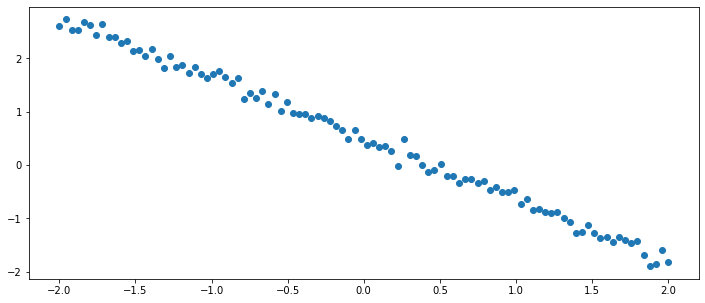

In [362]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, outputs)
plt.show()

### Predictions Without Optimisation

In [363]:
BETA = 2
ALPHA = .3
NUM_FEATURES = 2
MODEL_NOISE = 0.5
lengthscales = jnp.full((NUM_FEATURES, 1), .65) 
# lengthscales = jnp.load('1d_lengthscales.npy')
# coefs = jnp.full_like(lengthscales, 5.)
coefs = jnp.load('1d_coefs.npy')

model = prior(NUM_FEATURES, alpha=ALPHA)
model = train_transition_models(
    inputs, outputs, BETA, model, NUM_FEATURES, lengthscales, coefs, SEED
) 
print(model[0])

[ 0.48758522 -2.1192122 ]


In [364]:
key = SEED
N = 1000
state_predictions = np.zeros((xs.shape[0], N))
for i, state in enumerate(inputs):
    # key, subkey = jrandom.split(key)
    # state = jnp.array([[state]])
    next_state = state_prediction(state, model, MODEL_NOISE, NUM_FEATURES, lengthscales, coefs, BETA, N, key)
    state_predictions[i] = next_state.squeeze()


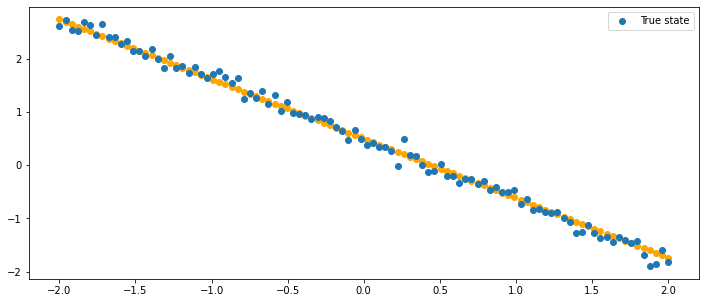

In [365]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, state_predictions.mean(axis=1), color='orange')
plt.scatter(xs, outputs, label="True state")
plt.legend()
plt.show()

### Predictions After Optimisation

In [296]:
BETA = 20.
ALPHA = 10.
NUM_FEATURES = 1000
MODEL_NOISE = 0.5
lengthscales = jnp.full((NUM_FEATURES, 1), .65) 
coefs = jnp.load('1d_coefs.npy')
# coefs = jnp.full_like(lengthscales, 0.3)

model = prior(NUM_FEATURES, alpha=ALPHA)
model_opt = train_transition_models(
    xs, outputs, BETA, model, NUM_FEATURES, lengthscales, coefs, SEED
) 

In [306]:
N = 1000
start_states = jnp.concatenate([jnp.array([[x]]) for x in xs])
obs_states = outputs
indices = jnp.arange(NUM_POINTS)

params = jnp.array([coefs])
optimizer = optax.chain(
    optax.adam(learning_rate=0.003),
    # optax.scale(-1.0)
)
opt_state = optimizer.init(params)

key = SEED
for i in range(100):    
    grads = grad_marg_lkhd(
        start_states, obs_states, model_opt, NUM_FEATURES, lengthscales, params[0],
        BETA, indices, MODEL_NOISE, 8, N, key
    )

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 10 == 0:
        objective = marginal_likelihood(
            start_states, obs_states, model_opt, NUM_FEATURES, lengthscales, params[0],
            BETA, indices, MODEL_NOISE, N, key
        )
        print(f"Step {i}, objective: {objective}")

np.save('1d_coefs.npy', params[0])

Step 0, objective: 1438.455078125
Step 10, objective: 1432.8587646484375
Step 20, objective: 1432.384033203125
Step 30, objective: 1430.518798828125
Step 40, objective: 1429.1513671875
Step 50, objective: 1428.6697998046875
Step 60, objective: 1428.068603515625
Step 70, objective: 1428.1090087890625
Step 80, objective: 1428.2374267578125
Step 90, objective: 1428.5780029296875


In [32]:
key = SEED
N = 1000
state_predictions2 = np.zeros_like(xs)
for i, x in enumerate(xs):
    key, subkey = jrandom.split(key)
    state = jnp.array([x])
    next_state = state_prediction(state, model_opt, MODEL_NOISE, NUM_FEATURES, lengthscales, coefs, BETA, N, subkey)
    state_predictions2[i] = next_state.squeeze().mean()


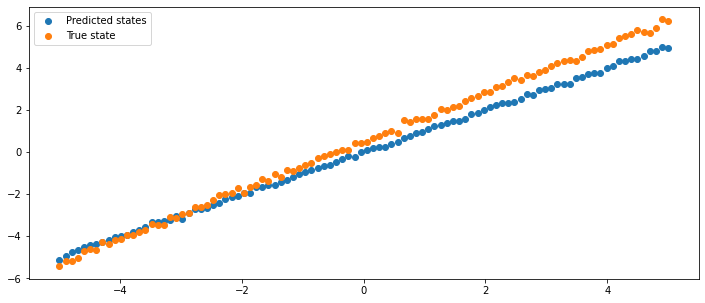

In [34]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, state_predictions2, label="Predicted states")
plt.scatter(xs, samples, label="True state")
plt.legend()
plt.show()

### Radial Basis Functions

In [412]:
WEIGHTS = jnp.array([0.5, -1.15, 0.5, 9.])
NOISE = 0.1

def sample(xs, epsilons):
    ins = jnp.stack([jnp.array([1., x, x ** 2, jnp.sin(x)]) for x in xs])
    outs = ins @ WEIGHTS + epsilons * NOISE
    return ins, outs

In [428]:
SEED = jrandom.PRNGKey(1)
NUM_POINTS = 20
xs = np.linspace(-10., 10., NUM_POINTS)
epsilons = jrandom.normal(SEED, shape=(NUM_POINTS,))
inputs, outputs = sample(xs, epsilons)

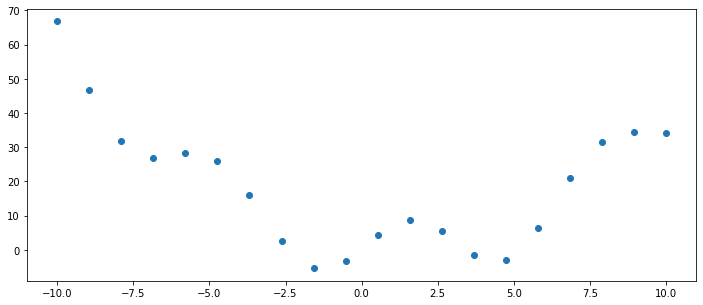

In [429]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, outputs)
plt.show()

In [430]:
NUM_BASES = 50
theta = jrandom.normal(SEED, shape=(NUM_BASES, 3))


params = jnp.array([theta])
optimizer = optax.chain(
    optax.adam(learning_rate=0.1),
    # optax.scale(-1.0)
)
opt_state = optimizer.init(params)
for i in range(300):
    grads = jacobian(get_loss, 2)(xs, outputs, params[0])

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 20 == 0:
        cur_loss = get_loss(xs, outputs, params[0])
        print(f"Step {i}, loss: {cur_loss}")

theta = params[0]

Step 0, loss: 13984.2080078125
Step 20, loss: 10062.4296875
Step 40, loss: 3762.20361328125
Step 60, loss: 1240.294677734375
Step 80, loss: 536.2706909179688
Step 100, loss: 188.5140838623047
Step 120, loss: 83.59539031982422
Step 140, loss: 28.31559944152832
Step 160, loss: 8.248394966125488
Step 180, loss: 2.007723331451416
Step 200, loss: 0.8013561964035034
Step 220, loss: 0.22183829545974731
Step 240, loss: 0.5804699063301086
Step 260, loss: 0.15608662366867065
Step 280, loss: 0.21017152070999146


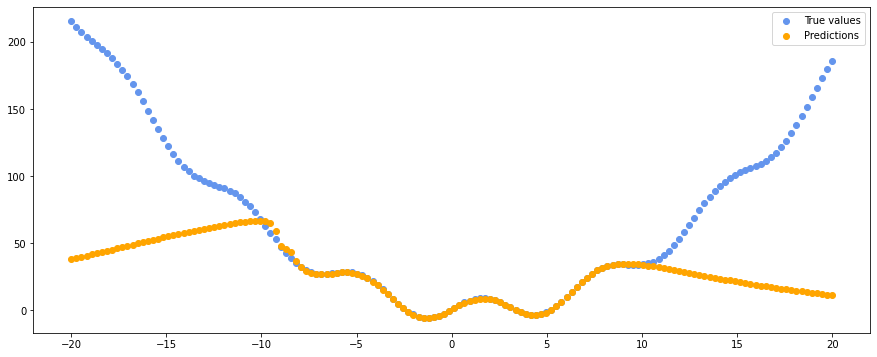

In [431]:
NUM_POINTS = 150
xs = np.linspace(-20., 20., NUM_POINTS)
epsilons = jrandom.normal(SEED, shape=(NUM_POINTS,))
outputs = sample(xs, epsilons)[1]

pred_ys = vmap(rbf_out, (0, None))(xs, theta)

plt.figure(figsize=(15, 6))
plt.scatter(xs, outputs, color='cornflowerblue', label="True values")
plt.scatter(xs, pred_ys, color='orange', label="Predictions")
plt.legend()
plt.show()